# MadMiner particle physics tutorial

# Part 2b: Analyzing events at Delphes level

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this second part of the tutorial, we'll generate events and extract the observables and weights from them. You have two options: In this notebook we'll do this with Delphes, in the alternative part 2a we stick to parton level.

## 0. Preparations

Before you execute this notebook, make sure you have working installations of MadGraph, Pythia, and Delphes.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


from madminer.core import MadMiner
from madminer.delphes import DelphesReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [3]:
mg_dir = '/home/llr/cms/cortinovis/EFT2Obs/MG5_aMC_v2_6_7'

## 1. Generate events

Let's load our setup:

In [21]:
miner = MadMiner()
miner.load("data/setup.h5")

12:40 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
12:40 madminer.core.madmin INFO    Found 2 parameters:
12:40 madminer.core.madmin INFO       CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
12:40 madminer.core.madmin INFO       CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
12:40 madminer.core.madmin INFO    Found 6 benchmarks:
12:40 madminer.core.madmin INFO       sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
12:40 madminer.core.madmin INFO       w: CWL2 = 15.20, CPWL2 = 0.10
12:40 madminer.core.madmin INFO       neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
12:40 madminer.core.madmin INFO       ww: CWL2 = 0.30, CPWL2 = 15.10
12:40 madminer.core.madmin INFO       neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
12:40 madminer.core.madmin INFO       morphing_basis_vector_5: CWL2 = 16.90, CPWL2 = -1.99e+01
12:40 madminer.core.madmin INFO    Found morphing setup with 6 components
12:40 madminer.core.madmin INFO    Did not f

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You can use `run()` or `run_multiple()`; the latter allows to generate different runs with different run cards and optimizing the phase space for different benchmark points. 

In either case, you have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` (or in the case of `run_all`, `sample_benchmarks`) option can be used to specify which benchmark should be used for sampling, i.e. for which benchmark point the phase space is optimized. If you just use one benchmark, reweighting to far-away points in parameter space can lead to large event weights and thus large statistical fluctuations. It is therefore often a good idea to combine at least a few different benchmarks for this option. Here we use the SM and the benchmark "w" that we defined during the setup step.

One slight annoyance is that MadGraph only supports Python 2. The `run()` and `run_multiple()` commands have a keyword `initial_command` that let you load a virtual environment in which `python` maps to Python 2 (which is what we do below). Alternatively / additionally you can set `python2_override=True`, which calls `python2.7` instead of `python` to start MadGraph.

In [22]:
miner.run(
    sample_benchmark='sm',
    temp_directory = './',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal_pythia',
    proc_card_file='cards/proc_card_signal_hzz4l_noj.dat',
    param_card_template_file='cards/param_card_template.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    run_card_file='cards/run_card_signal_small.dat',
    log_directory='logs/signal',
    initial_command="PYTHONPATH=/usr/lib64/python",
    python2_override=True,
)



12:40 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal_hzz4l_noj.dat at ./mg_processes/signal_pythia
12:40 madminer.core.madmin INFO    Run 0
12:40 madminer.core.madmin INFO      Sampling from benchmark: sm
12:40 madminer.core.madmin INFO      Original run card:       cards/run_card_signal_small.dat
12:40 madminer.core.madmin INFO      Original Pythia8 card:   cards/pythia8_card.dat
12:40 madminer.core.madmin INFO      Original config card:    None
12:40 madminer.core.madmin INFO      Copied run card:         /madminer/cards/run_card_0.dat
12:40 madminer.core.madmin INFO      Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
12:40 madminer.core.madmin INFO      Copied config card:      None
12:40 madminer.core.madmin INFO      Param card:              /madminer/cards/param_card_0.dat
12:40 madminer.core.madmin INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
12:40 madminer.core.madmin INFO      Log file:        

In [4]:
additional_benchmarks = ['w', 'ww', 'neg_w', 'neg_ww']

In [24]:
miner.run_multiple(
    sample_benchmarks=additional_benchmarks,
    mg_directory=mg_dir,
    temp_directory = './',
    mg_process_directory='./mg_processes/signal_pythia2',
    proc_card_file='cards/proc_card_signal_hzz4l_noj.dat',
    param_card_template_file='cards/param_card_template.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    run_card_files=['cards/run_card_signal_small.dat'],
    log_directory='logs/signal',
    initial_command="PYTHONPATH=/usr/lib64/python",
    python2_override=True,
)

13:17 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal_hzz4l_noj.dat at ./mg_processes/signal_pythia2
13:17 madminer.core.madmin INFO    Run 0
13:17 madminer.core.madmin INFO      Sampling from benchmark: w
13:17 madminer.core.madmin INFO      Original run card:       cards/run_card_signal_small.dat
13:17 madminer.core.madmin INFO      Original Pythia8 card:   cards/pythia8_card.dat
13:17 madminer.core.madmin INFO      Original config card:    None
13:17 madminer.core.madmin INFO      Copied run card:         /madminer/cards/run_card_0.dat
13:17 madminer.core.madmin INFO      Copied Pythia8 card:     /madminer/cards/pythia8_card_0.dat
13:17 madminer.core.madmin INFO      Copied config card:      None
13:17 madminer.core.madmin INFO      Param card:              /madminer/cards/param_card_0.dat
13:17 madminer.core.madmin INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
13:17 madminer.core.madmin INFO      Log file:        

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there (LHE and HepMC), do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

### Backgrounds

We can also easily add other processes like backgrounds. An important option is the `is_background` keyword, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [ ]:
"""
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background_pythia',
    proc_card_file='cards/proc_card_background.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
)
"""

Finally, note that both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 2. Run Delphes

The `madminer.delphes.DelphesReader` class wraps around Delphes, a popular fast detector simulation, to simulate the effects of the detector.

In [82]:
delphes = DelphesReader('data/setup.h5')

10:09 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.


After creating the `DelphesReader` object, one can add a number of event samples (the output of running MadGraph and Pythia in step 1 above) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [83]:
delphes.add_sample(
    lhe_filename='mg_processes/signal_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1.1, #Why??
)

for i, benchmark in enumerate(additional_benchmarks):
    delphes.add_sample(
        lhe_filename='mg_processes/signal_pythia2/Events/run_0{}/unweighted_events.lhe.gz'.format(i+1),
        hepmc_filename='mg_processes/signal_pythia2/Events/run_0{}/tag_1_pythia8_events.hepmc.gz'.format(i+1),
        sampled_from_benchmark=benchmark,
        is_background=False,
        k_factor=1.1,
    )

"""
delphes.add_sample(
    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',
    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.0,
"""


10:09 madminer.delphes.del DEBUG   Adding event sample mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
10:09 madminer.delphes.del DEBUG   Adding event sample mg_processes/signal_pythia2/Events/run_01/tag_1_pythia8_events.hepmc.gz
10:09 madminer.delphes.del DEBUG   Adding event sample mg_processes/signal_pythia2/Events/run_02/tag_1_pythia8_events.hepmc.gz
10:09 madminer.delphes.del DEBUG   Adding event sample mg_processes/signal_pythia2/Events/run_03/tag_1_pythia8_events.hepmc.gz
10:09 madminer.delphes.del DEBUG   Adding event sample mg_processes/signal_pythia2/Events/run_04/tag_1_pythia8_events.hepmc.gz


"\ndelphes.add_sample(\n    lhe_filename='mg_processes/background_pythia/Events/run_01/unweighted_events.lhe.gz',\n    hepmc_filename='mg_processes/background_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz',\n    sampled_from_benchmark='sm',\n    is_background=True,\n    k_factor=1.0,\n"

Now we run Delphes on these samples (you can also do this externally and then add the keyword `delphes_filename` when calling `DelphesReader.add_sample()`):

In [84]:
delphes.run_delphes(
    delphes_directory=mg_dir + '/HEPTools/Delphes-3.4.2',
    delphes_card='cards/delphes_card_CMS.dat',
    log_file='logs/delphes.log',
)

10:09 madminer.delphes.del INFO    Running Delphes on HepMC sample at mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz
10:09 madminer.utils.inter DEBUG   Unzipping mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events.hepmc.gz


KeyboardInterrupt: 

## 3. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [ ]:
delphes.add_observable(
    'isZZcand',
    'isZZcand',
    required=True,
)

delphes.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=float('nan'),
)

delphes.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=False,
    default=float('nan'),
)

delphes.add_observable(
    'delta_eta_jj',
    'j[0].deltaeta(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=False,
    default=float('nan'),
)

delphes.add_observable(
    'm_jj',
    '(j[0]+j[1]).m',
    required=False,
    default=float('nan'),
)

delphes.add_observable(
    'H_pt',
    '(lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).pt',
    required=True,
)

delphes.add_observable(
    'H_m',
    '(lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).m',
    required=True,
)

delphes.add_observable(
    'Z1_pt',
    '(lep1ZZ+lep2ZZ).pt',
    required=True,
)

delphes.add_observable(
    'Z2_pt',
    '(lep3ZZ+lep4ZZ).pt',
    required=True,
)

delphes.add_observable(
    'H_eta',
    '(lep1ZZ+lep2ZZ+lep3ZZ+lep4ZZ).eta',
    required=True,
)

delphes.add_observable(
    'n_jets',
    'len(j)',
    required=True,
)

delphes.add_observable(
    'met',
    'met.pt',
    required=True,
)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [53]:
delphes.add_cut('isZZcand == 1')
delphes.add_cut('pt_j1 > 20.')

"delphes.add_cut('(a[0] + a[1]).m > 122.')\ndelphes.add_cut('(a[0] + a[1]).m < 128.')\ndelphes.add_cut('pt_j1 > 20.')"

## 4. Analyse events and store data

The function `analyse_samples` then calculates all observables from the Delphes file(s) generated before and checks which events pass the cuts:

In [49]:
delphes.analyse_delphes_samples()

14:37 madminer.delphes.del INFO    Analysing Delphes sample mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root: Calculating 7 observables, requiring 0 selection cuts, associated with no systematics
14:37 madminer.delphes.del DEBUG   Extracting nuisance parameter definitions from LHE file
14:37 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal_pythia/Events/run_01/unweighted_events.lhe.gz
14:37 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
14:37 madminer.utils.inter DEBUG   1 weight groups
14:37 madminer.delphes.del DEBUG   systematics_dict: OrderedDict()
14:37 madminer.utils.inter DEBUG   Parsing Delphes file mg_processes/signal_pythia/Events/run_01/tag_1_pythia8_events_delphes.root
14:37 madminer.utils.inter DEBUG   Not extracting weights
14:37 madminer.utils.inter DEBUG   Found 100000 events
14:39 madminer.utils.inter DEBUG     First 10 values for observable pt_lead_j:
[0. 0. 0. 0. 0. 0. 0. 0. 0.

14:49 madminer.utils.inter DEBUG   Event 1 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 2 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 3 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 4 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 5 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 6 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 7 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 8 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Event 9 passes observations, passes cuts, passes efficiencies -> passes
14:49 madminer.utils.inter DEBUG   Ev

14:55 root                 DEBUG   Merging data extracted from this file with data from previous files
14:55 root                 DEBUG     Weights for benchmark sm exist in both
14:55 root                 DEBUG     Weights for benchmark w exist in both
14:55 root                 DEBUG     Weights for benchmark neg_w exist in both
14:55 root                 DEBUG     Weights for benchmark ww exist in both
14:55 root                 DEBUG     Weights for benchmark neg_ww exist in both
14:55 root                 DEBUG     Weights for benchmark morphing_basis_vector_5 exist in both
14:55 madminer.delphes.del INFO    Analysing Delphes sample mg_processes/signal_pythia2/Events/run_03/tag_1_pythia8_events_delphes.root: Calculating 7 observables, requiring 0 selection cuts, associated with no systematics
14:55 madminer.delphes.del DEBUG   Extracting nuisance parameter definitions from LHE file
14:55 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/si

15:06 madminer.utils.inter DEBUG     First 10 values for observable H_mass:
[nan nan nan nan nan nan nan nan nan nan]
15:07 madminer.utils.inter DEBUG     First 10 values for observable H_pt:
[nan nan nan nan nan nan nan nan nan nan]
15:07 madminer.utils.inter DEBUG     First 10 values for observable H_eta:
[nan nan nan nan nan nan nan nan nan nan]
15:07 madminer.utils.inter DEBUG     100000 / 100000 events pass required observable m_jj
15:07 madminer.utils.inter DEBUG     11596 / 100000 events pass required observable lep1_pt
15:07 madminer.utils.inter DEBUG     11596 / 100000 events pass required observable H_mass
15:07 madminer.utils.inter DEBUG     11596 / 100000 events pass required observable H_pt
15:07 madminer.utils.inter DEBUG     11596 / 100000 events pass required observable H_eta
15:07 madminer.utils.inter INFO      11596 / 100000 events pass everything
15:07 madminer.delphes.del DEBUG   Did not extract weights from Delphes file
15:07 madminer.delphes.del DEBUG   Found 1159

In [50]:
delphes.save('data/delphes_data.h5')

16:47 madminer.delphes.del DEBUG   Loading HDF5 data from data/setup.h5 and saving file to data/delphes_data.h5
16:47 madminer.delphes.del DEBUG   Weight names: ['sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5']
16:47 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
16:47 madminer.utils.inter DEBUG   Benchmark morphing_basis_vector_5 already in benchmark_names_phys
16:47 madminer.utils.inter DEBUG   Benchmark neg_w already in benchmark_names_phys
16:47 madminer.utils.inter DEBUG   Benchmark neg_ww already in benchmark_names_phys
16:47 madminer.utils.inter DEBUG   Benchmark sm already in benchmark_names_phys
16:47 madminer.utils.inter DEBUG   Benchmark w already in benchmark_names_phys
16:47 madminer.utils.inter DEBUG   Benchmark ww already in benchmark_names_phys
16:47 madminer.utils.inter DEBUG   Combined benchmark names: ['sm', 'w', 'neg_w', 'ww', 'neg_ww', 'morphing_basis_vector_5']
16:47 madminer.utils.inter DEBUG   Combined is_nuisance: [0 0

## 5. Plot distributions

Let's see what our MC run produced:

16:47 madminer.analysis.da INFO    Loading data from data/delphes_data.h5
16:47 madminer.analysis.da INFO    Found 2 parameters
16:47 madminer.analysis.da DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:47 madminer.analysis.da DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
16:47 madminer.analysis.da INFO    Did not find nuisance parameters
16:47 madminer.analysis.da INFO    Found 6 benchmarks, of which 6 physical
16:47 madminer.analysis.da DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:47 madminer.analysis.da DEBUG      w: CWL2 = 15.20, CPWL2 = 0.10
16:47 madminer.analysis.da DEBUG      neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
16:47 madminer.analysis.da DEBUG      ww: CWL2 = 0.30, CPWL2 = 15.10
16:47 madminer.analysis.da DEBUG      neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
16:47 madminer.analysis.da DEBUG      morphing_basis_vector_5: CWL2 = 16.90, CPWL2 = -1.99e+01
16:47 madminer.analysis.da INFO    Foun

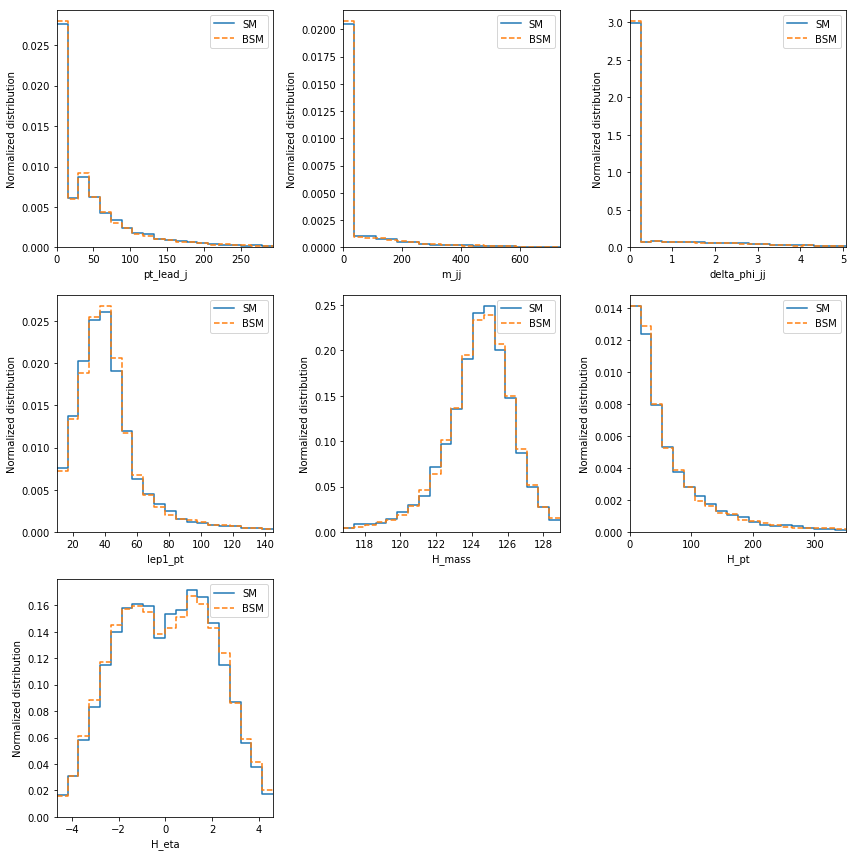

In [51]:
_ = plot_distributions(
    filename='data/delphes_data.h5',
    parameter_points=['sm', np.array([10.,0.])],
    line_labels=['SM', 'BSM'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=True,
)

## 6. Combine and shuffle different samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

This is generally good practice even if you use just one sample, since the events might have some inherent ordering (e.g. from sampling from different hypotheses). Later when we split the events into a training and test fraction, such an ordering could cause problems.

In [55]:
combine_and_shuffle(
    ['data/delphes_data.h5'],
    'data/delphes_data_shuffled.h5'
)

16:55 madminer.sampling.co DEBUG   Combining and shuffling samples
16:55 madminer.sampling.co DEBUG   Copying setup from data/delphes_data.h5 to data/delphes_data_shuffled.h5
16:55 madminer.sampling.co DEBUG   Loading samples from file 1 / 1 at data/delphes_data.h5, multiplying weights with k factor 1.0
16:55 madminer.sampling.co DEBUG   Sampling benchmarks: [2 3 3 ... 2 3 0]
16:55 madminer.sampling.co DEBUG   Combined sampling benchmarks: [2 3 3 ... 2 3 0]
16:55 madminer.sampling.co DEBUG   Recalculated event numbers per benchmark: [11684 11952 12591 11526 11596     0], background: 0


In [62]:
import h5py

def get_all(name):
    print(name)

with h5py.File('data/delphes_data.h5', 'r') as f:
    g_name = f.visit(get_all)
    d = f['samples/observations']
    print(len([a for a in d[:,0] if a!=0]))
    print(len(d[:,0]))
    #for item in d[:]:
        #print(item[1])

benchmarks
benchmarks/is_nuisance
benchmarks/is_reference
benchmarks/names
benchmarks/values
morphing
morphing/components
morphing/morphing_matrix
observables
observables/definitions
observables/names
parameters
parameters/lha_blocks
parameters/lha_ids
parameters/max_power
parameters/names
parameters/ranges
parameters/transforms
sample_summary
sample_summary/background_events
sample_summary/signal_events_per_benchmark
samples
samples/observations
samples/sampling_benchmarks
samples/weights
35472
59349


In [75]:
l#a = np.nanmax(float('nan'),8)
np.nanmax([8,float('nan')])

8.0

In [71]:
print(a)

nan
